In [1]:
class QuotientFilter:
    def __init__(self, q, r):

        self.q = q
        self.r = r
        self.size = 1 << q  
        self.table = [None] * self.size
        self.occupied = [False] * self.size
        self.runends = [False] * self.size
        
        
    def _hash(self, item):
        if isinstance(item, str):
            item = item.encode()
        hash_val = hash(item) & ((1 << (self.q + self.r)) - 1)
        quotient = hash_val >> self.r
        remainder = hash_val & ((1 << self.r) - 1)
        return quotient, remainder
    
    def insert(self, item):
        quotient, remainder = self._hash(item)
        
        if self.occupied[quotient]:
            start = quotient
            while start > 0 and self.occupied[start - 1]:
                start -= 1
            
            pos = start
            while pos < quotient:
                if self.table[pos] is None:
                    break
                pos += 1
            else:
                while pos < self.size and self.occupied[pos] and self.table[pos] is not None:
                    pos += 1
            
            if pos >= self.size:
                pos = 0
                while pos < quotient and self.occupied[pos] and self.table[pos] is not None:
                    pos += 1
            
            if pos < quotient:
                for i in range(pos, quotient):
                    if self.table[i] is None:
                        self.table[i] = self.table[i-1]
                        self.runends[i] = self.runends[i-1]
                        self.runends[i-1] = False
                self.table[quotient] = remainder
                self.runends[quotient] = True
            else:
                self.table[pos] = remainder
                self.runends[pos] = True
        else:
            self.table[quotient] = remainder
            self.runends[quotient] = True
        
        self.occupied[quotient] = True
    
    def lookup(self, item):
        quotient, remainder = self._hash(item)
        
        if not self.occupied[quotient]:
            return False
        
        start = quotient
        while start > 0 and self.occupied[start - 1]:
            start -= 1
        
        pos = start
        while pos < self.size and self.occupied[pos]:
            if self.table[pos] == remainder:
                return True
            if self.runends[pos]:
                break
            pos += 1
        
        return False
    
    def delete(self, item):
        quotient, remainder = self._hash(item)
        
        if not self.occupied[quotient]:
            return False
        
        start = quotient
        while start > 0 and self.occupied[start - 1]:
            start -= 1
        
        pos = start
        found_pos = -1
        while pos < self.size and self.occupied[pos]:
            if self.table[pos] == remainder:
                found_pos = pos
            if self.runends[pos]:
                break
            pos += 1
        
        if found_pos == -1:
            return False
        
        self.table[found_pos] = None
        
        if found_pos == quotient:
            has_other = False
            pos = start
            while pos < self.size and self.occupied[pos]:
                if pos != found_pos and (self._get_quotient(pos) == quotient):
                    has_other = True
                    break
                if self.runends[pos]:
                    break
                pos += 1
            
            if not has_other:
                self.occupied[quotient] = False
                self.runends[quotient] = False
        
        return True
    
    def _get_quotient(self, pos):
        start = pos
        while start > 0 and self.occupied[start - 1]:
            start -= 1
        
        current = start
        quotient = None
        while current <= pos:
            if self.runends[current]:
                quotient = current
            current += 1
        
        return quotient
    
    def __contains__(self, item):
        return self.lookup(item)
    
    def __repr__(self):
        return f"QuotientFilter(q={self.q}, r={self.r}, size={self.size})"

In [2]:
qf = QuotientFilter(10, 4)

qf.insert("712cetbg")
qf.insert("39gyfhau")
qf.insert("ra4j5pgoipongdae")

print("712cetbg" in qf)    
print("39gyfhau" in qf)   
print("ra4j5pgoipongdae" in qf)    

qf.delete("ra4j5pgoipongdae")
print("ra4j5pgoipongdae" in qf)   

True
True
True
False


In [3]:
import random
import string

def generate_random_string(length=10):
    return ''.join(random.choices(string.ascii_letters + string.digits, k=length))

def measure_false_positive_rate(q, r, num_inserted, num_tested):

    qf = QuotientFilter(q, r)
    
    inserted_elements = set()
    while len(inserted_elements) < num_inserted:
        item = generate_random_string()
        if item not in inserted_elements:
            qf.insert(item)
            inserted_elements.add(item)
    
    tested_elements = set()
    while len(tested_elements) < num_tested:
        item = generate_random_string()
        if item not in inserted_elements and item not in tested_elements:
            tested_elements.add(item)
    
    false_positives = 0
    for item in tested_elements:
        if item in qf:
            false_positives += 1
    
    false_positive_rate = (false_positives / num_tested) * 100
    return false_positive_rate

Q = 10
R = 6
NUM_INSERTED = 500
NUM_TESTED = 10000

fp_rate = measure_false_positive_rate(Q, R, NUM_INSERTED, NUM_TESTED)
print(f"Процент ложноположительных срабатываний: {fp_rate:.2f}%")

Процент ложноположительных срабатываний: 0.56%



Результаты:


,q,r,table_size,False Positive Rate (%)
0,8,4,256,5.620000
1,8,6,256,1.640000
2,8,8,256,0.313333
3,10,4,1024,2.246667
4,10,6,1024,0.553333
5,10,8,1024,0.166667
6,12,4,4096,0.820000
7,12,6,4096,0.213333
8,12,8,4096,0.046667


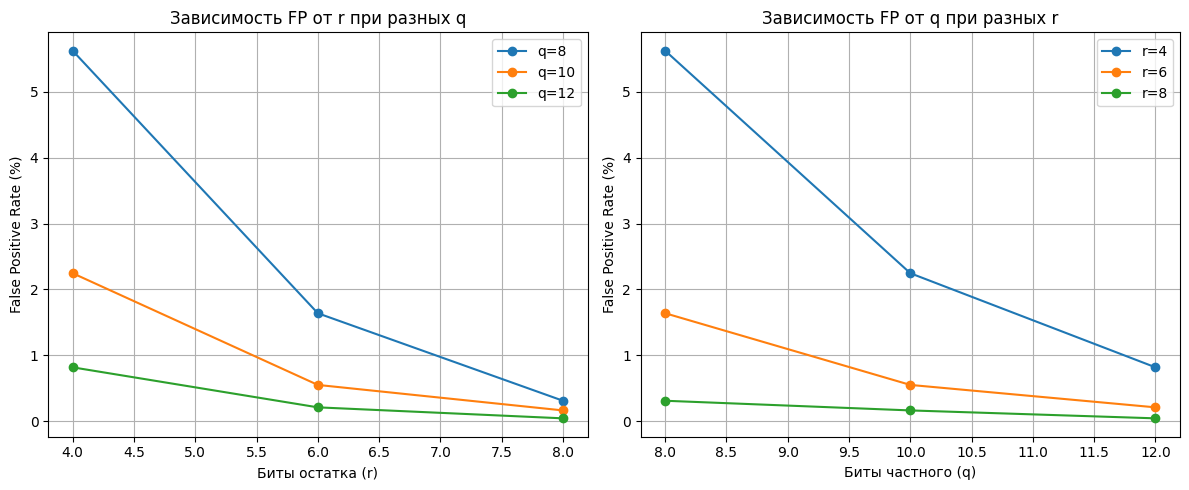

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import string

def generate_random_string(length=10):
    return ''.join(random.choices(string.ascii_letters + string.digits, k=length))

def analyze_quotient_filter_performance():
    q_values = [8, 10, 12]
    r_values = [4, 6, 8]
    num_inserted = 500
    num_tested = 5000
    trials = 3
    
    results = []
        
    for q in q_values:
        for r in r_values:
            if q + r > 64:
                continue
                
            total_fp = 0
            
            for _ in range(trials):
                qf = QuotientFilter(q, r)
                
                inserted_elements = set()
                while len(inserted_elements) < num_inserted:
                    item = generate_random_string()
                    if item not in inserted_elements:
                        qf.insert(item)
                        inserted_elements.add(item)
                
                tested_elements = set()
                while len(tested_elements) < num_tested:
                    item = generate_random_string()
                    if item not in inserted_elements and item not in tested_elements:
                        tested_elements.add(item)
                
                false_positives = 0
                for item in tested_elements:
                    if item in qf:
                        false_positives += 1
                
                total_fp += (false_positives / num_tested) * 100
            
            avg_fp = total_fp / trials
            
            results.append({
                'q': q,
                'r': r,
                'table_size': 2 ** q,
                'False Positive Rate (%)': avg_fp
            })
    
    df = pd.DataFrame(results)
    
    print("\nРезультаты:")
    display(df[['q', 'r', 'table_size', 'False Positive Rate (%)']]
            .sort_values(['q', 'r']))
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    for q_val in q_values:
        subset = df[df['q'] == q_val]
        plt.plot(subset['r'], subset['False Positive Rate (%)'], 
                marker='o', label=f'q={q_val}')
    plt.xlabel('Биты остатка (r)')
    plt.ylabel('False Positive Rate (%)')
    plt.title('Зависимость FP от r при разных q')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    for r_val in r_values:
        subset = df[df['r'] == r_val]
        plt.plot(subset['q'], subset['False Positive Rate (%)'], 
                marker='o', label=f'r={r_val}')
    plt.xlabel('Биты частного (q)')
    plt.ylabel('False Positive Rate (%)')
    plt.title('Зависимость FP от q при разных r')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return df

results_df = analyze_quotient_filter_performance()